In [15]:
import sys
from pathlib import Path
import numpy as np

PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))


import tensorflow as tf
from tensorflow.keras.models import model_from_json

from model.model import Model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
artifacts_dir = "data"

In [17]:
def high_freq_mae(y_true, y_pred):
    # y_true/pred shape: (Batch, 512, 512, 1)
    frequencies = tf.range(512, dtype=tf.float32)
    weights = 1.0 + (frequencies / 512.0) * 4.0  
    weights = tf.reshape(weights, (1, 512, 1, 1))
    
    mae = tf.abs(y_true - y_pred)
    weighted_mae = mae * weights
    
    return tf.reduce_mean(weighted_mae)

In [18]:
with open(f"{artifacts_dir}/mod_unet_last_weights_v15.json", "r") as f:
    model = model_from_json(f.read(), custom_objects={'high_freq_mae': high_freq_mae})

model.load_weights(f"{artifacts_dir}/mod_unet_last_weights_v15.weights.h5")

/home/misha/repo/Cassette-denoising/venv_tf2/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 48 variables whereas the saved optimizer has 94 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
denoiser = Model(
    model=model,
    weights=None,
    model_name="unet_denoiser",
    sample_rate=44100,
    min_duration=1.0,
    frame_length=262144, # 262655
    hop_length_frame=131072, #131072
    n_fft=1023,
    hop_length_fft=512
)

In [25]:
denoiser.predict(artifacts_dir, ["ELO_1_raw.wav"], "3_test_v15_with_overlap.wav", headroom=0.02)

Spectrogram dimension: 512
4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step
Denoised spectrogram shape: (99, 512, 512)
Phase shape: (99, 512, 512)
Overlap detected. Using Hann window Overlap-Add with hop_length_frame=131072
Output audio shape: (13107200,)
Output amplitude range: [-0.9680, 47.9950]


In [21]:
# model = tf.keras.models.load_model(f"{artifacts_dir}/model_best.karas", compile=False)

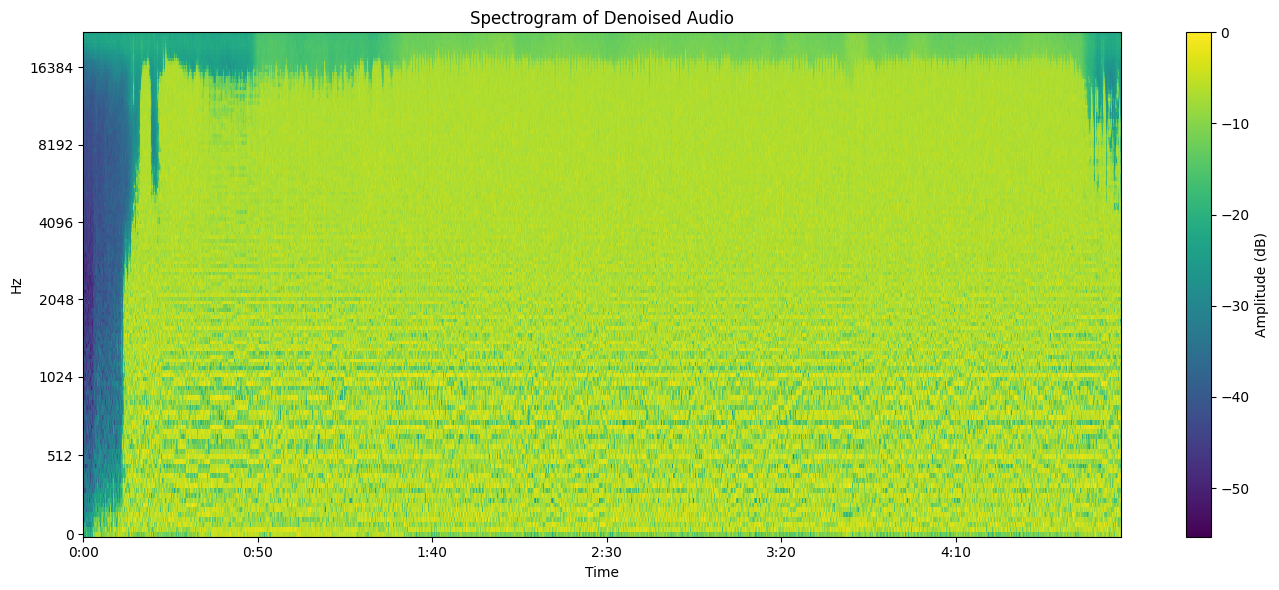

In [22]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Load the denoised audio
audio_path = f"{artifacts_dir}/2_test_v15_with_overlap.wav"
y, sr = librosa.load(audio_path, sr=None)

# Compute the spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.power_to_db(S, ref=np.max)

# Display the spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
plt.colorbar(label='Amplitude (dB)')
plt.title('Spectrogram of Denoised Audio')
plt.tight_layout()
plt.show()